# Evaluating Task Performance

## Introduction

All medical images are created for a purpose, to detect, diagnose, quantify, monitor, etc. For this reason, [OIC](https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.4881148) 

**Add bit to recruit results.csv for task performance, maybe add oct2py wrapper for LCD-CT**

## 1. Making a Low Contrast Detectability Dataset

Using the simulation tools provided by [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms), make a dataset of the MITA-LCD phantom (Catphan 600 CCT189 Module) at 10 dose levels with 200 repeats each using a Siemens Somatom Definition AS Scanner, this can be done with the following config file and the [`make_phantoms`](https://pediatriciqphantoms.readthedocs.io/en/latest/usage.html#command-line-interface) command line program available after [installing pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms?tab=readme-ov-file#start-here):

```toml
# LCD.toml

[[simulation]]

# directories
image_directory = "/gpfs_projects/brandon.nelson/RSTs/LCD-CT"
# phantoms
model = ['MITA-LCD', 'uniform'] # <-- current options include ['CTP404', 'MITA-LCD', 'UNIFORM']
diameter = [200] # <-- units in mm
reference_diameter = 200 # <-- diameter in mm of the real phantom for comparison

# acquisition
framework = "MIRT" # CT simulation framework options include ['MIRT'] <https://github.com/JeffFessler/mirt>
nsims = 200 # <-- number of simulations to perform with different noise instantiations
ndetectors = 880           # number of detector columns (set it to be large enough to cover the projected FOV to avoid truncation)
nangles = 1160 # <-- number of views in a rotation (na=1160 based on ZengEtAl2015-IEEE-NuclearScience-v62n5:"A Simple Low-Dose X-Ray CT Simulation From High-Dose Scan")
aec_on = true # (aec built in to ped xcat) <-- 'aec' = automatic exposure control, when `true`, it ensures constant noise levels for all `patient_diameters` (see `reference_dose_level` for more info)
add_noise = true # <-- if true adds Poisson noise, noise magnitude set by `reference_dose_level`, noise texture set by reconstructed field of view (currently fov = 110# patient_diameter) 
full_dose = 3e5 # <-- units of photons per pixel
dose_level = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # <-- units of photons in list

# acquisition geometry # CT geometry (the following parameter values simulate Siemens Force) 
sid = 595          #(mm) source-to-isocenter distance (value based on AAPM LDCT data dicom header)
sdd = 1085.6          # source-to-detector distance
# isocenter-to-detector distance dod = sdd - sid 
                      
detector_size = 1        # detector column size 
detector_offset = 1.25    # lateral shift of detector

# reconstruction
fov = 340  # <-- FOV in mm of adult protocol used in scanning real physical phantom for comparison
matrix_size = 512 # <-- reconstructed matrix size in pixels (square, equal on both sides)
fbp_kernel = 'hanning,2.05' # 'hanning,xxx', xxx = the cutoff frequency, see fbp2_window.m in MIRT for details.
                        #'hanning,2.05' approximate a sharp kernel D45 in Siemens Force.
                        #'hanning, 0.85' approximate a smooth kernel B30 in
                        #Siemens Force.
```

Then run the simulation using `make_phantoms`:

```bash
make_phantoms LCD.toml
```

The result as a simulated dataset of 200 repeats of the MITA-LCD phantom simulated on a Siemens Somatom Definition AS CT scanner at 10 increasing dose levels.

We can then use the Low Contrast Detectability CT Toolbox (LCD-CT) to evaluate detectability as a function of dose as demonstrated below:

(a pre-generated version is also available for download from **Zenodo (TODO)**, or use the smaller dataset)

In [1]:
!ls /gpfs_projects/brandon.nelson/RSTs/LCD-CT/uniform/diameter200mm/

'20.0 cm uniform_groundtruth.dcm'   dose_020   dose_050   dose_080
'20.0 cm uniform_noisefree.dcm'     dose_030   dose_060   dose_090
 dose_010			    dose_040   dose_070   dose_100


In [2]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/

diameter112mm  diameter185mm  diameter292mm	ground_truth.raw
diameter131mm  diameter200mm  diameter350mm	metadata.csv
diameter151mm  diameter216mm  ground_truth.mhd	summary.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base_dir = Path('/gpfs_projects/brandon.nelson/RSTs/LCD-CT/')

# base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/')

meta = pd.read_csv(base_dir / 'metadata.csv')
meta.file = meta.file.apply(lambda o: base_dir / o)
meta = meta[meta.phantom.isin(['MITA-LCD', 'uniform'])]
meta

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,20.0 cm MITA-LCD,0,30000.0 photons 20.0 cm MITA-LCD 10% dose fbp D45,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,0,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
1,20.0 cm MITA-LCD,0,30000.0 photons 20.0 cm MITA-LCD 10% dose fbp D45,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,1,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
2,20.0 cm MITA-LCD,0,30000.0 photons 20.0 cm MITA-LCD 10% dose fbp D45,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,2,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
3,20.0 cm MITA-LCD,0,30000.0 photons 20.0 cm MITA-LCD 10% dose fbp D45,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,3,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
4,20.0 cm MITA-LCD,0,30000.0 photons 20.0 cm MITA-LCD 10% dose fbp D45,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),10.0,fbp,fbp D45,34.0,4,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999,20.0 cm uniform,0,300000.0 photons 20.0 cm uniform 100% dose fbp...,9,simulation,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,197,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/unif...
4000,20.0 cm uniform,0,300000.0 photons 20.0 cm uniform 100% dose fbp...,9,simulation,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,198,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/unif...
4001,20.0 cm uniform,0,300000.0 photons 20.0 cm uniform 100% dose fbp...,9,simulation,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,199,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/unif...
4002,20.0 cm uniform,0,300000.0 photons 20.0 cm uniform 100% dose fbp...,9,noise free,20.0,2,infant,uniform,Siemens Definition AS+ (simulated),NaN,fbp,fbp D45,34.0,0,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/unif...


In [4]:
sorted(meta['effective diameter [cm]'].unique()), meta.series.unique()

([20.0], array(['simulation', 'noise free', 'ground truth'], dtype=object))

In [5]:
diam = 20
dose = 100
recon = 'fbp'
sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]
sample.head()

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
1800,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,0,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
1801,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,1,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
1802,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,2,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
1803,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,3,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...
1804,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,9,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,4,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...


In [6]:
meta[(meta['effective diameter [cm]']==diam) & (meta.phantom == 'MITA-LCD') & (meta.series == 'ground truth')]

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
2001,20.0 cm MITA-LCD,0,300000.0 photons 20.0 cm MITA-LCD 100% dose fb...,9,ground truth,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),NaN,fbp,fbp D45,34.0,0,/gpfs_projects/brandon.nelson/RSTs/LCD-CT/MITA...


In [7]:
meta.phantom.unique()

array(['MITA-LCD', 'uniform'], dtype=object)

In [8]:
import pydicom
import numpy as np
def load_dicom(dcm_file):
    dcm = pydicom.dcmread(dcm_file)
    return (dcm.pixel_array + int(dcm.RescaleIntercept)).astype(float)

In [9]:
diam = 20
dose = 100
recon = 'fbp'
sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]

sa_fname = sample[sample.phantom=='uniform'].file
sa_vol = np.array([load_dicom(o) for o in sa_fname])

sp_fname = sample[sample.phantom=='MITA-LCD'].file
sp_vol = np.array([load_dicom(o) for o in sp_fname])

sp_gt_vol = load_dicom(meta[(meta['effective diameter [cm]']==diam) &
                            (meta.phantom == 'MITA-LCD') &
                            (meta.series == 'ground truth')].file.item())

sp_vol.shape, sa_vol.shape, sp_gt_vol.shape

((200, 512, 512), (200, 512, 512), (512, 512))

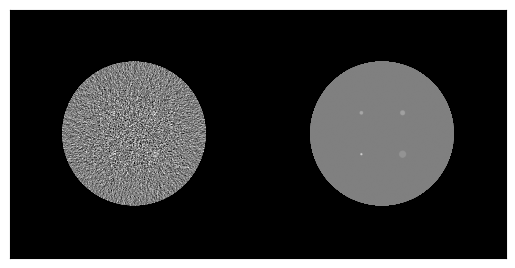

In [10]:
from utils import ctshow
ctshow(np.concatenate([sp_vol[0], sp_gt_vol], axis=1), (40, 0))

In [11]:
# octave.pwd()

In [17]:
from oct2py import octave
import os

def measure_LCD(sp_vol, sa_vol, sp_gt_vol, observers=['LG_CHO_2D']):
    # octave.cd('../src/LCD')
    signal_present_array = sp_vol.transpose(1,2,0)
    signal_absent_array = sa_vol.transpose(1,2,0)
    octave.addpath('classes')
    octave.addpath('functions')
    res = octave.measure_LCD(signal_present_array, signal_absent_array, sp_gt_vol, observers)
    res = {k:v.squeeze() for k,v in res.items()}
    return pd.DataFrame(res)

In [18]:
res = measure_LCD(sp_vol, sa_vol, sp_gt_vol, observers=['LG_CHO_2D', 'NPWE_2D'])
res.head()

,observer,insert_HU,snr,auc,reader
0,Laguerre-Gauss CHO 2D,5.0,-0.133490,0.4623,1.0
1,Laguerre-Gauss CHO 2D,5.0,0.206833,0.5544,2.0
2,Laguerre-Gauss CHO 2D,5.0,-0.070853,0.4919,3.0
3,Laguerre-Gauss CHO 2D,5.0,0.228261,0.5861,4.0
4,Laguerre-Gauss CHO 2D,5.0,0.186692,0.5416,5.0


<Axes: xlabel='insert_HU', ylabel='auc'>

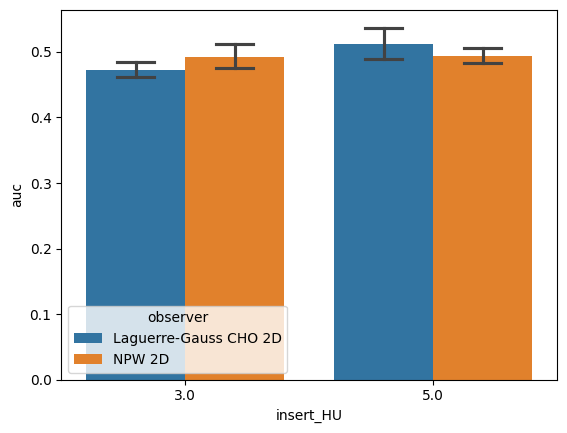

In [19]:
import seaborn as sns
sns.barplot(data=res, x='insert_HU', y='auc', capsize=0.3, hue='observer')

In [20]:
meta['recon'].unique()

array(['fbp'], dtype=object)

In [21]:
df_list = []
for dose in meta['Dose [%]'].dropna().unique():
    for diam in meta['effective diameter [cm]'].unique():
        for recon in meta['recon'].unique():
            sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]

            sa_fname = sample[sample.phantom=='uniform'].file
            sa_vol = np.array([load_dicom(o) for o in sa_fname])

            sp_fname = sample[sample.phantom=='MITA-LCD'].file
            sp_vol = np.array([load_dicom(o) for o in sp_fname])

            sp_gt_vol = load_dicom(meta[(meta['effective diameter [cm]']==diam) &
                                        (meta.phantom == 'MITA-LCD') &
                                        (meta.series == 'ground truth')].file.item())

            sample_df = measure_LCD(sp_vol, sa_vol, sp_gt_vol)
            sample_df['effective diameter [cm]'] = diam
            sample_df['Dose [%]'] = dose
            sample_df['recon'] = recon
            df_list.append(sample_df)
results = pd.concat(df_list)

In [22]:
results

,observer,insert_HU,snr,auc,reader,effective diameter [cm],Dose [%],recon
0,Laguerre-Gauss CHO 2D,5.0,0.186926,0.5497,1.0,20.0,10.0,fbp
1,Laguerre-Gauss CHO 2D,5.0,0.101691,0.5262,2.0,20.0,10.0,fbp
2,Laguerre-Gauss CHO 2D,5.0,-0.059828,0.4700,3.0,20.0,10.0,fbp
3,Laguerre-Gauss CHO 2D,5.0,-0.131029,0.4678,4.0,20.0,10.0,fbp
4,Laguerre-Gauss CHO 2D,5.0,0.252662,0.5715,5.0,20.0,10.0,fbp
...,...,...,...,...,...,...,...,...
15,Laguerre-Gauss CHO 2D,3.0,0.020620,0.5007,6.0,20.0,100.0,fbp
16,Laguerre-Gauss CHO 2D,3.0,0.056106,0.5258,7.0,20.0,100.0,fbp
17,Laguerre-Gauss CHO 2D,3.0,0.020841,0.5110,8.0,20.0,100.0,fbp
18,Laguerre-Gauss CHO 2D,3.0,-0.071984,0.4830,9.0,20.0,100.0,fbp


In [ ]:
sns.lineplot(data=results,
             x='Dose [%]',
             y='auc',
             hue='recon',
             style='observer',
             hue_order=recon_order)

Looks like denoising only helps with the really low contrast and larger lesions